In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
from loadmodules import *
import scipy as sp
from numba import njit, config
config.THREADING_LAYER = 'omp'

In [2]:
%matplotlib inline

In [3]:
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl5_f' in directory]
print(simulation_list)

['Au6_lvl5_f9742_k12_fiducial']


# ICMF sampling test

In [4]:
sf = load_subfind(127, dir=path+simulation_list[0]+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(127, snappath=path+simulation_list[0]+'/output/', subfind=sf, hdf5=True, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = 0.1 * sf.data['frc2'][0]
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

/users/aripcont/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.01940984129905701
Found 81245 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.07407439,  0.9054877 ,  0.41785763],
       [ 0.27226892,  0.42145283, -0.8650128 ],
       [-0.95936574,  0.04969435, -0.27775502]])

In [5]:
solar_mass_g = 1.989e33
Gcosmo = 43.
k = 1.3807e-16 # boltzmann constant in erg/K (g*cm^2/s^2/K)
parsec = 3.08567758e18 # cm

s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']
s.data['bprs'] *= s.parameters['UnitMass_in_g'] / s.parameters['UnitLength_in_cm'] / (s.parameters['UnitTime_in_s']**2)
s.data['bdens'] *= s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**3)

In [6]:
starparts = s.data['type']==4
imclus = s.data['imcl'][s.data['incl']>0].flatten()*s.UnitMass_in_g/solar_mass_g
imtotclus = s.data['imfc'][s.data['incl']>0]*s.data['mass'][starparts][s.data['incl']>0]*s.UnitMass_in_g/solar_mass_g
inclus = s.data['incl'][s.data['incl']>0].flatten()
mtrunc = s.data['mtrc'][s.data['incl']>0] * s.UnitMass_in_g/solar_mass_g

In [7]:
mask_problematic = s.data['imfc']>1.
print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][s.data['incl']>0]) * 100))

Problematic stars with clusters  247
That`s 1.419 per cent of stars with clusters


In [8]:
stars_age = s.cosmology_get_lookback_time_from_a(s.data['age'], is_flat=True)

/users/aripcont/pylib/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


In [9]:
def ICMF(norm, m, mtrunc):
    return norm*np.exp(-m/mtrunc)/m**2

def mICMF(norm, m, mtrunc):
    return norm*m*np.exp(-m/mtrunc)/m**2

def trapz_log(norm, min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(norm, current, mtrunc) + IMF(norm, next, mtrunc))
    return integral

In [10]:
nbins = 25
min_gcmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(np.log10(marray_gcmf))

N,_ = np.histogram(imclus[imclus>0], bins=marray_gcmf, density=True)
initial_population = N/width

In [11]:
norm = 1/trapz_log(1., min_gcmf, max_gcmf, mtrunc, ICMF, 500)
norm_real = 1/trapz_log(1., 1e2, max_gcmf, mtrunc, ICMF, 500)


In [12]:
mean_mclus = trapz_log(norm_real, 1e2, max_gcmf, mtrunc, mICMF, 500)
nexp_clus = (s.data['lcfe'][s.data['incl']>0]*s.data['gima'][s.data['incl']>0]*1e10)/mean_mclus

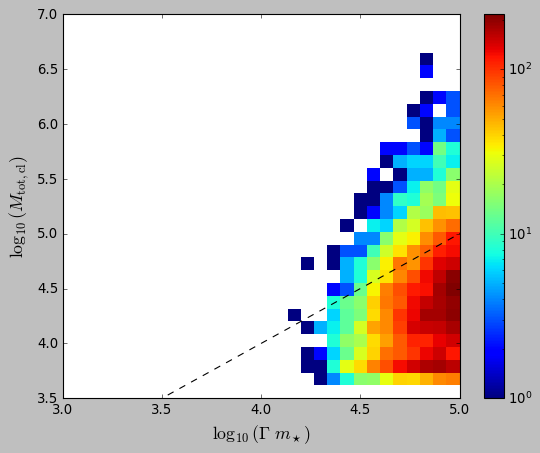

In [14]:
cb = plt.hist2d(np.log10(s.data['lcfe'][s.data['incl']>0]*s.data['gima'][s.data['incl']>0]*1e10),
           np.log10(s.data['imfc'][s.data['incl']>0]*s.data['gima'][s.data['incl']>0]*1e10), range=([3,5], [3.5,7]), bins=(30,30),rasterized=True, norm=mcolors.LogNorm())
plt.plot(np.linspace(3,7, 50), np.linspace(3,7, 50), 'k--')
plt.xlim(3,5)
plt.ylim(3.5,7)
plt.xlabel(r'$\log_{10} ( \Gamma \; m_\star)$', fontsize=16)
plt.ylabel(r'$\log_{10} ( M_{\rm{tot,cl}})$', fontsize=16)
plt.colorbar(cb[3])

In [15]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(ICMF(norm[i], marray_gcmf, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

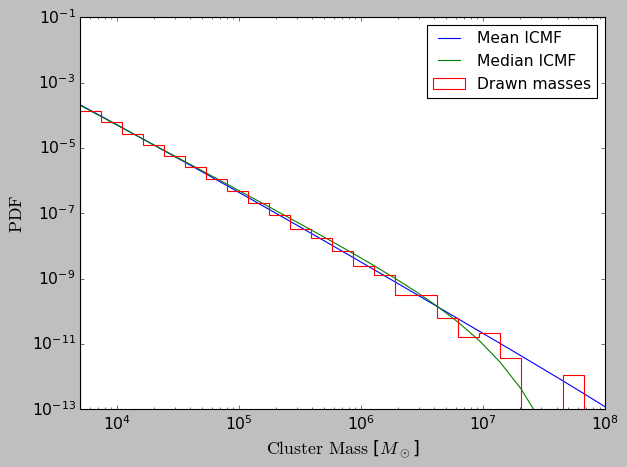

In [16]:
plt.loglog(marray_gcmf, np.mean(ICMF_array,axis=0), label='Mean ICMF')
plt.loglog(marray_gcmf, np.median(ICMF_array,axis=0), label='Median ICMF')
# plt.hist(imtotclus/inclus, bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
plt.hist(imclus[imclus>0], bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
# plt.step(marray_gcmf[:-1], initial_population, where='post', label='Initial Population')
plt.legend(fontsize=14)
plt.ylim(1e-13, 1e-1)
plt.xlim(min_gcmf, max_gcmf)
plt.xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.yticks(np.logspace(-13, -1, 7))
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/icmf_sampling_test_consistent.pdf')

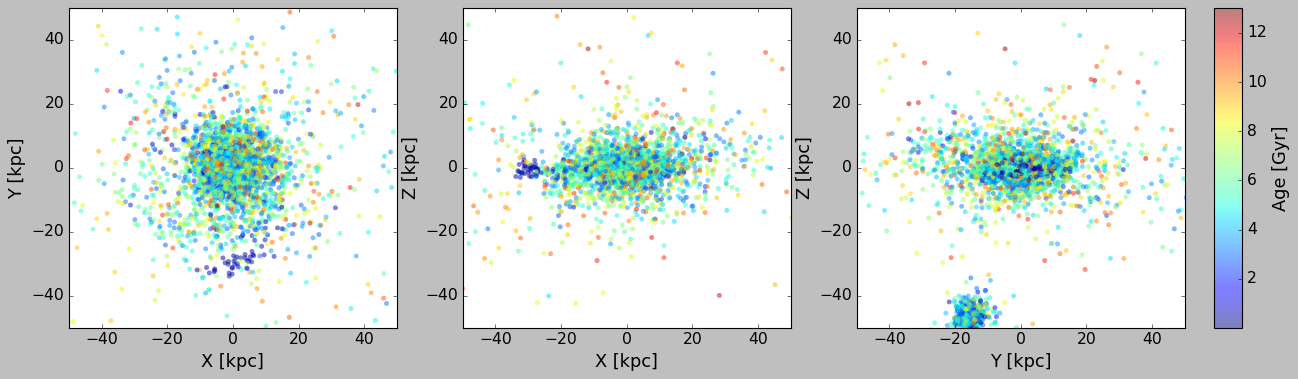

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,50)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[2].set_xlim(-50,50)
ax[2].set_ylim(-50,50)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

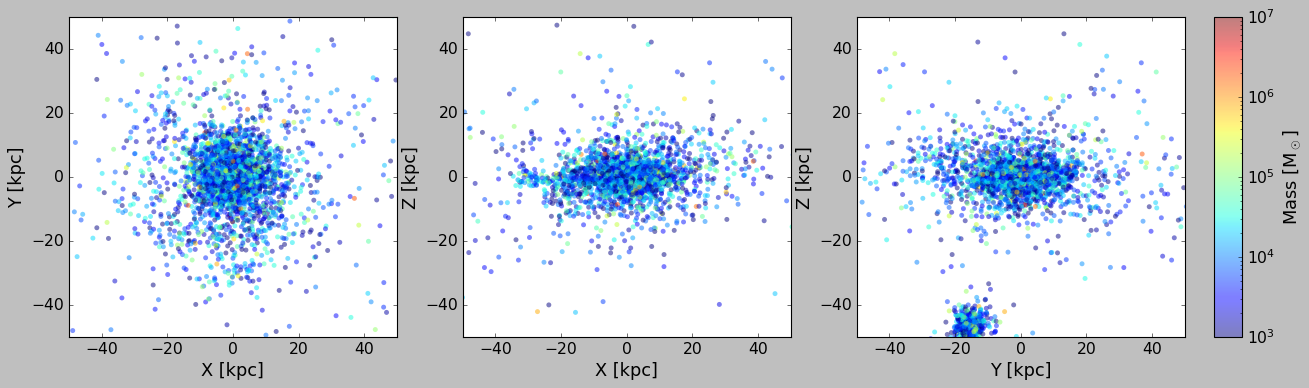

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,50)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[2].set_xlim(-50,50)
ax[2].set_ylim(-50,50)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Mass [M$_\odot$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_mass_distribution.pdf')

In [19]:
mclus = s.data['mclt'][s.data['nclt']>0].flatten()
mclus = mclus[mclus>0]
nclus = s.data['nclt'][s.data['nclt']>0]

In [20]:
kinetic_energy = np.sum(s.data['vel']**2, axis=1)
# print(kinetic_energy)

orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
orbital_energy /= 1e5
# print(orbital_energy.min(),orbital_energy.max())
e_max = orbital_energy.max()
orbital_energy -= e_max
# print(orbital_energy.min(),orbital_energy.max())
J_mod = np.sqrt((np.cross(s.data['pos'], s.data['vel'])**2).sum(axis=1))
Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
Lz *= np.sign(np.nanmedian(Lz))

parts_radius = s.r()
isort_parts = np.argsort(parts_radius)
revert_sort = np.argsort(isort_parts)
cummass = np.cumsum(s.data['mass'][isort_parts])
Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
Ecirc /= 1e5
Ecirc -= e_max

/tmp/ipykernel_3232498/3084747548.py:18: RuntimeWarning: divide by zero encountered in divide
  Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)


In [21]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

# Example usage
mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

In [22]:
r_test = np.logspace(-5, np.log10(parts_radius.max()), 5000)
Ecirc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
Vc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
Mr_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask])

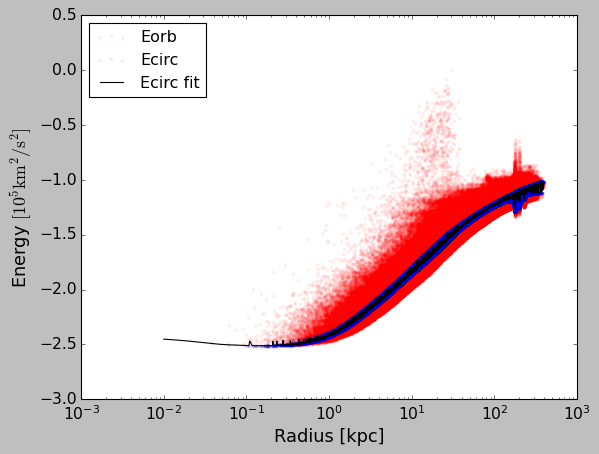

In [23]:
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], orbital_energy[isort_parts][~np.isinf(Ecirc)][mask], c='r', edgecolors='face', label='Eorb', s=5, alpha=0.05)
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], edgecolors='face', label='Ecirc', s=5, alpha=0.05)
plt.plot(1e3*r_test, Ecirc_f(r_test), c='k', label='Ecirc fit')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Energy $[10^5 \rm{km}^2/\rm{s}^2]$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

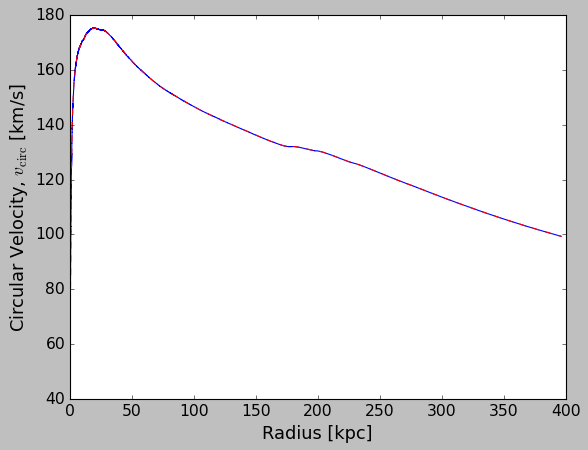

In [24]:
plt.plot(1e3*parts_radius[isort_parts], Vc_parts[isort_parts])
plt.plot(1e3*r_test, Vc_f(r_test), 'r--')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Circular Velocity, $v_{\rm{circ}}$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14)

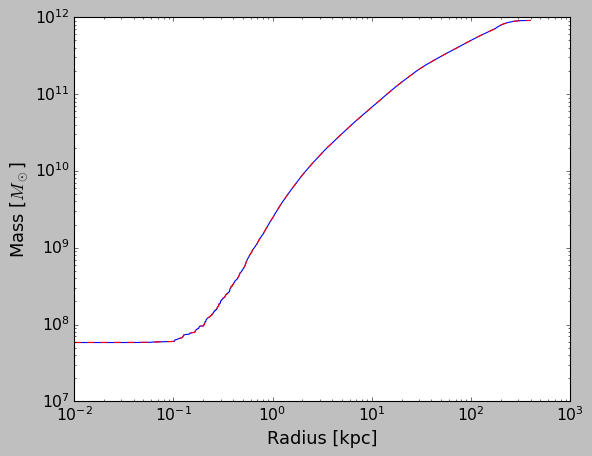

In [25]:
plt.plot(1e3*parts_radius[isort_parts], 1e10*cummass)
plt.plot(1e3*r_test, 1e10*Mr_f(r_test), 'r--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Mass [$M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [26]:
@njit(parallel=True)
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    velocity_dispersion = np.std(velocities)
    return velocity_dispersion

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

In [27]:
idx = np.argmin(np.abs(orbital_energy[starparts][s.data['nclt']>0][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
rc_clus = r_test[idx]
vc_rc_clus = Vc_f(rc_clus)
M_rc_clus = Mr_f(rc_clus)
sigma_rc_clus = np.array([velocity_dispersion(rc, parts_radius, starparts, s.data['age'], s.data['vel'], s.data['type']) for rc in rc_clus])

rc_clus = np.repeat(rc_clus, nclus)
M_rc_clus = np.repeat(M_rc_clus, nclus)
vc_rc_clus = np.repeat(vc_rc_clus, nclus)
sigma_rc_clus = np.repeat(sigma_rc_clus, nclus)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [28]:
r_clus = np.repeat(parts_radius[starparts][s.data['nclt']>0],nclus)
vc_clus = np.repeat(Vc_parts[starparts][s.data['nclt']>0],nclus)

(0.0, 500.0)

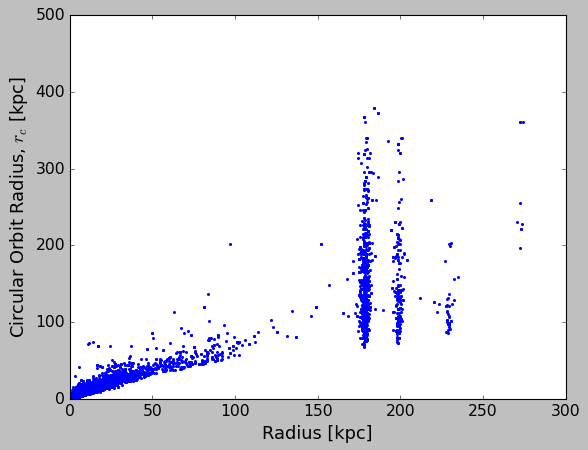

In [29]:
plt.scatter(1e3*r_clus,1e3*rc_clus, s=3, edgecolors='face')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.xlim(0,300)
plt.ylim(0,500)

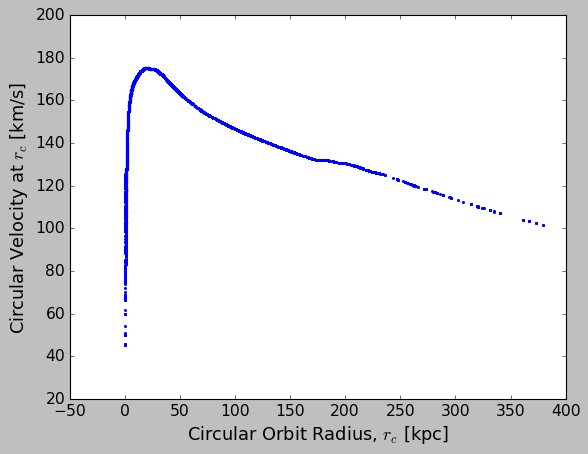

In [30]:
plt.scatter(1e3*rc_clus,vc_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Circular Velocity at $r_c$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

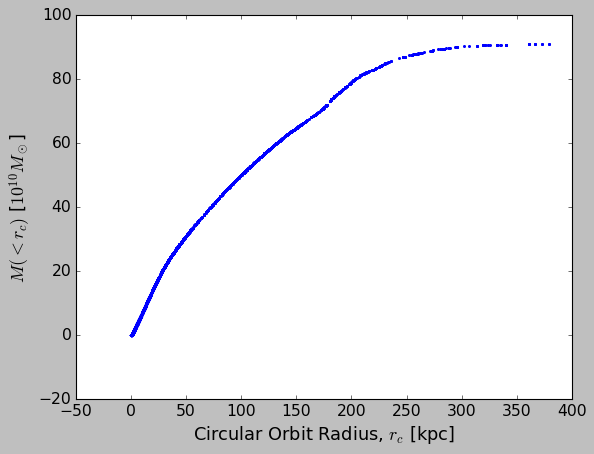

In [31]:
plt.scatter(1e3*rc_clus,M_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel(r'$M(<r_c)$ [$10^{10} M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

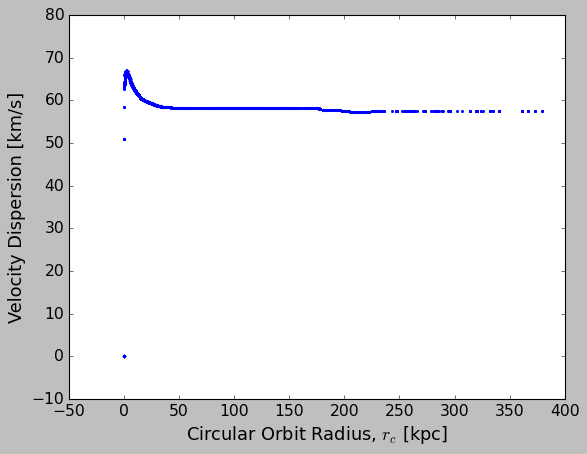

In [32]:
plt.scatter(1e3*rc_clus,sigma_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Velocity Dispersion [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [33]:
Jc_clus = rc_clus*vc_clus
circ_param_clus0 = np.repeat(Lz[starparts],s.data['nclt'])/Jc_clus
circ_param_clus1 = (np.repeat(J_mod[starparts],s.data['nclt'])/Jc_clus)

In [34]:
circ_param_clus0.min(),circ_param_clus0.max(), circ_param_clus1.min(), circ_param_clus1.max()

(-68.07455026218427,
 57.775750271689155,
 0.015781248344055566,
 68.69516908057143)

In [35]:
feps = (circ_param_clus1)**0.78
coulumblog = np.log(1. + M_rc_clus/mclus)

In [36]:
tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*mclus*coulumblog)
tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)
np.nanmin(tdf), np.nanmax(tdf)
clus_age = np.repeat(stars_age[s.data['nclt']>0],nclus)
mask_disrupted = (tdf<clus_age)
mask_disrupted.sum()

/tmp/ipykernel_3232498/1173968311.py:1: RuntimeWarning: divide by zero encountered in divide
  tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*mclus*coulumblog)
/tmp/ipykernel_3232498/2253337401.py:18: RuntimeWarning: invalid value encountered in multiply
  return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)


15

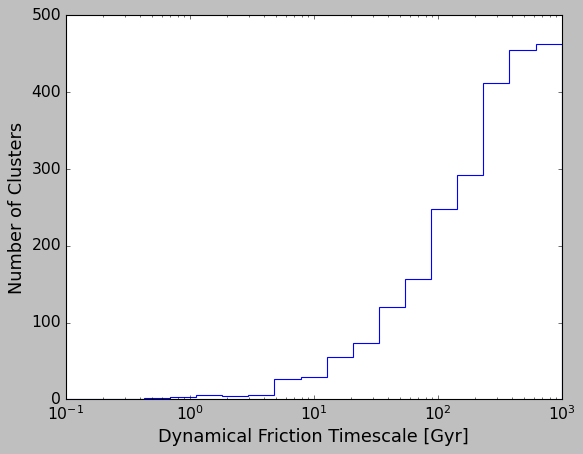

In [37]:
plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
plt.xscale('log')
plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
plt.ylabel('Number of Clusters', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

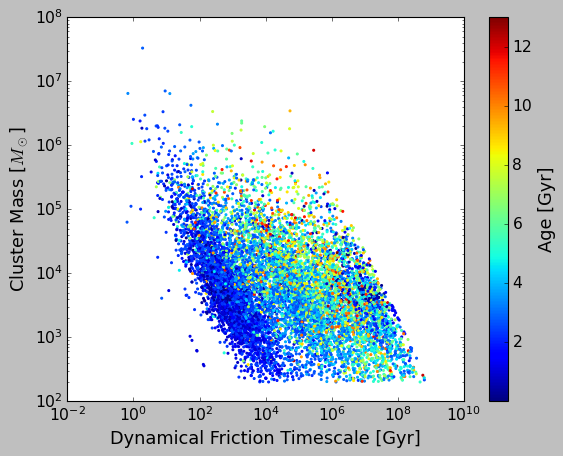

In [38]:
cb = plt.scatter(tdf, 1e10*mclus, s=3, c=clus_age, edgecolors='face')
plt.xscale('log')
plt.yscale('log')
cbar = plt.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
plt.ylabel('Cluster Mass [$M_\odot$]', fontsize=16)
xticks = plt.xticks()[0]
plt.xticks(xticks[::2])
plt.tick_params(axis='both', which='both', labelsize=14)

In [39]:
nbins = 20
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

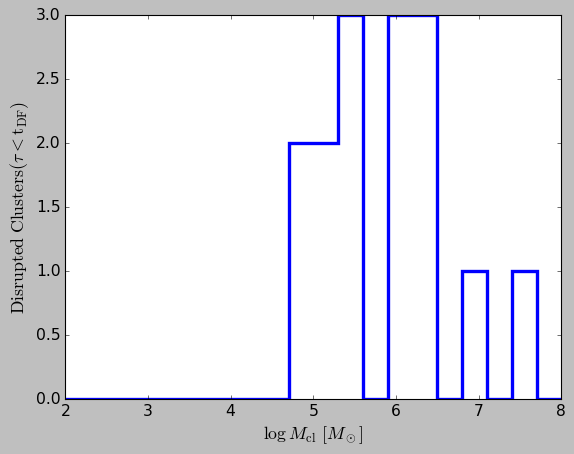

In [40]:
plt.hist(np.log10(1e10*mclus[mask_disrupted]), bins=marray_gcmf, histtype='step', label='All Clusters', linewidth=3)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\rm{Disrupted \; Clusters} (\tau < t_{\rm{DF}})$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

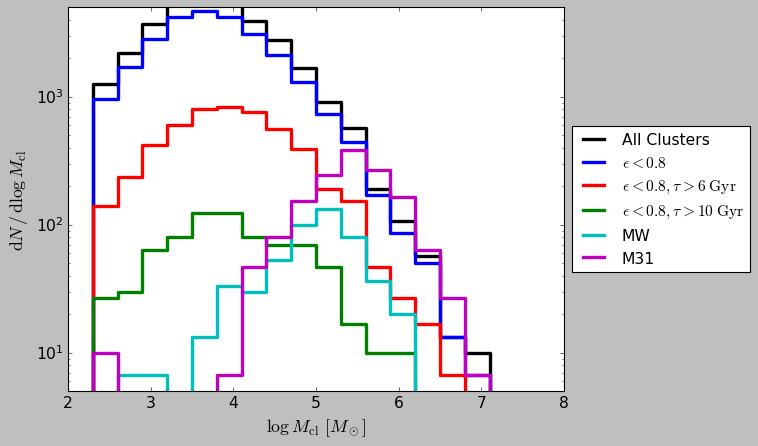

In [41]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width

N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted)]), bins=marray_gcmf)
all_clusters = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) * (circ_param_clus0<0.8)]), bins=marray_gcmf)
after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) * (clus_age>6.) * (circ_param_clus0<0.8)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) *(clus_age>10.) * (circ_param_clus0<0.8)]), bins=marray_gcmf)
after_df_old = N/width

plt.step(marray_gcmf[:-1], all_clusters, where='post',c='k', linewidth = 3, label='All Clusters')
plt.step(marray_gcmf[:-1], after_df, where='post',c='b', linewidth = 3, label=r'$\epsilon < 0.8$')
plt.step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3, label=r'$\epsilon < 0.8, \tau > 6 \; \rm{Gyr}$')
plt.step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3, label=r'$\epsilon < 0.8, \tau > 10 \; \rm{Gyr}$')
plt.step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='c', label='MW')
plt.step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='m', label='M31')
plt.yscale('log')
plt.ylim(5e0, 5e3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

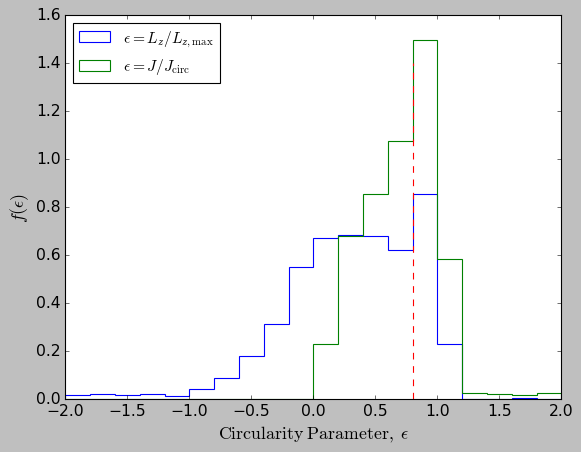

In [42]:
# plt.hist(circ_param[starparts][s.data['age']>0], histtype='step', density=True, bins=20, range=[-2.,2.])
plt.hist(circ_param_clus0, bins=20, range=[-2.,2.], histtype='step', density=True, label=r'$\epsilon=L_z / L_{z,\rm{max}}$')
plt.hist(circ_param_clus1, bins=20, range=[-2.,2.], histtype='step', density=True, label=r'$\epsilon=J / J_{\rm{circ}}$')
plt.legend(loc='upper left', fontsize=14)
plt.vlines(0.8,0,1.4, color='r', linestyles='dashed')
plt.xlabel(r'$\rm{Circularity \; Parameter}, \; \epsilon$', fontsize=16)
plt.ylabel(r'$f(\epsilon)$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

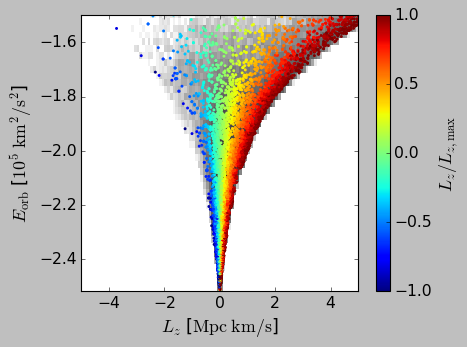

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
#index, = np.where((s.r() < 0.1) & (s.r() > 0.0))
ax.hist2d( Lz[starparts][s.data['age']>0.], orbital_energy[starparts][s.data['age']>0.], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][s.data['age']>0.].min(), 0.]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter( np.repeat(Lz[starparts],s.data['nclt']), np.repeat(orbital_energy[starparts],s.data['nclt']), c=circ_param_clus0, vmin=-1, vmax=1, s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][s.data['age']>0.].min(), -1.5)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label(r'$L_z / L_{z,\rm{max}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

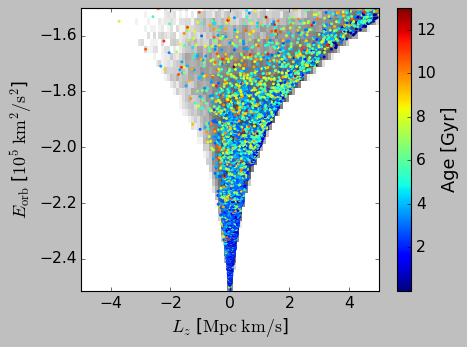

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.hist2d( Lz[starparts][s.data['age']>0.], orbital_energy[starparts][s.data['age']>0.], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][s.data['age']>0.].min(), 0.]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter( Lz[starparts][s.data['nclt']>0], orbital_energy[starparts][s.data['nclt']>0], c=stars_age[s.data['nclt']>0], s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][s.data['age']>0.].min(), -1.5)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

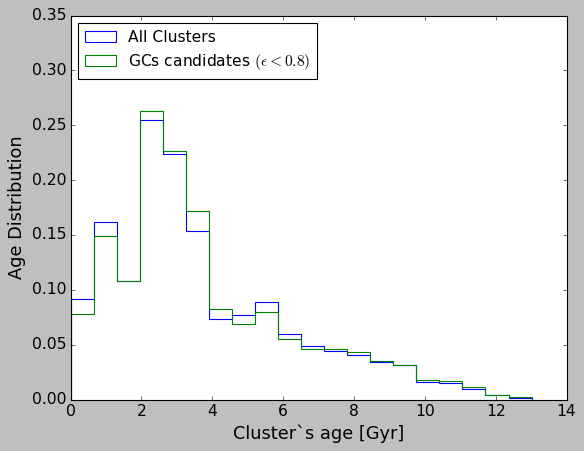

In [46]:
plt.hist(clus_age[~mask_disrupted], bins=20, histtype='step', density=True, label='All Clusters')
plt.hist(clus_age[(~mask_disrupted) * (circ_param_clus0 < 0.8)], bins=20, histtype='step', density=True, label=r'GCs candidates $(\epsilon < 0.8)$')
plt.ylim(0, 0.35)
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Cluster`s age [Gyr]', fontsize=16)
plt.ylabel('Age Distribution', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

/tmp/ipykernel_3232498/1820809098.py:1: RuntimeWarning: divide by zero encountered in log10
  logPoverk = np.repeat(np.log10(s.data['bprs'][s.data['age']>0.]/k), s.data['nclt'][s.data['age']>0.])


Text(0, 0.5, '$\\log P/k$ [$\\rm{K}/\\rm{cm}^3$]')

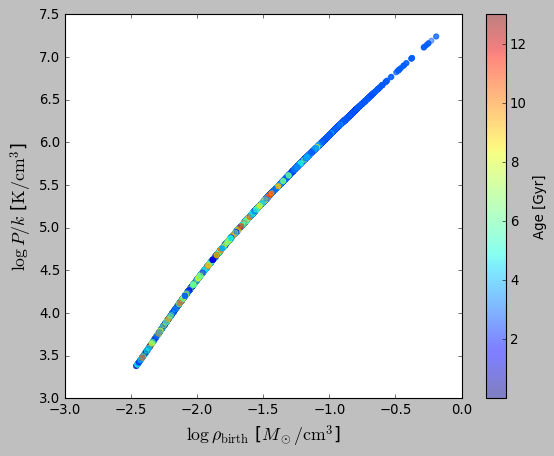

In [47]:
logPoverk = np.repeat(np.log10(s.data['bprs'][s.data['age']>0.]/k), s.data['nclt'][s.data['age']>0.])
logdens = np.repeat(np.log10(s.data['bdens'][s.data['age']>0.] * parsec**3/solar_mass_g), s.data['nclt'][s.data['age']>0.])

plt.scatter(logdens, logPoverk, c=clus_age, alpha=0.5, edgecolors='face')
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$\log \rho_{\rm{birth}}$ [$M_\odot/\rm{cm}^3$]', fontsize=16)
plt.ylabel(r'$\log P/k$ [$\rm{K}/\rm{cm}^3$]', fontsize=16)

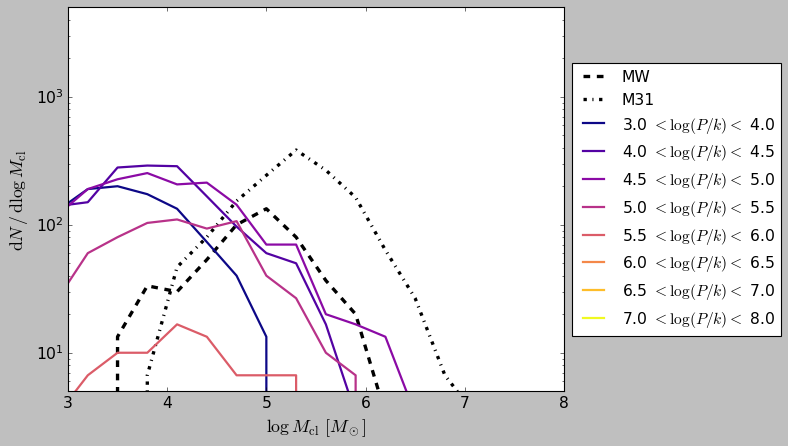

In [48]:
bins_logPoverk = np.concatenate([[3.0],np.arange(4,7.5,0.5),[8.0]])
colors = plt.cm.plasma(np.linspace(0, 1, 8))
plt.plot(marray_gcmf[:-1], mw_mass_function, 'k--', linewidth=3, label='MW')
plt.plot(marray_gcmf[:-1], m31_mass_function, 'k-.', linewidth=3, label='M31')
for i in range(8):
    mask = (logPoverk > bins_logPoverk[i]) & (logPoverk < bins_logPoverk[i+1])
    N,_ = np.histogram(np.log10(1e10*mclus[(~mask_disrupted) * (clus_age>6.) * (circ_param_clus0<0.8) * mask]), bins=marray_gcmf)
    after_df_intermediate = N/width
    plt.plot(marray_gcmf[:-1], after_df_intermediate, c=colors[i], linewidth = 2, label=f'{bins_logPoverk[i]:.1f} $< \log(P/k) <$ {bins_logPoverk[i+1]:.1f}')

plt.yscale('log')
plt.ylim(5e0, 5e3)
plt.xlim(3, 8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

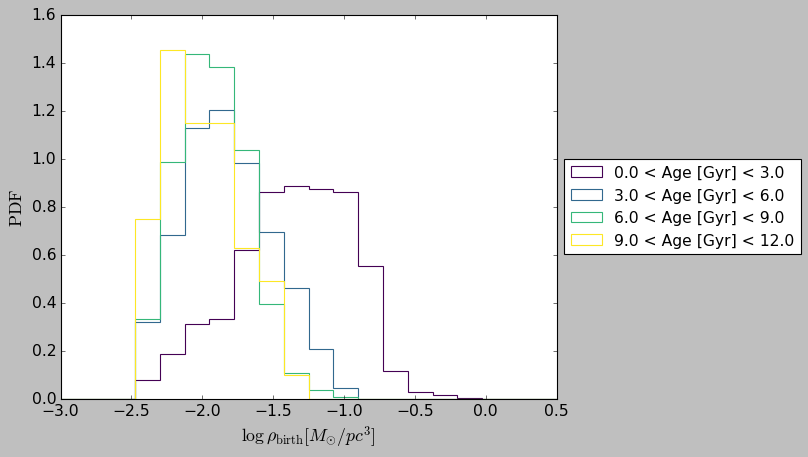

In [49]:
bins_ages = np.arange(0, 15, 3)
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for i in range(len(bins_ages)-1):
    mask = (clus_age > bins_ages[i]) & (clus_age < bins_ages[i+1])
    plt.hist(logdens[mask], bins=20, range=[-3, 0.5], histtype='step', density=True, color=colors[i], label=f'{bins_ages[i]:.1f} < Age [Gyr] < {bins_ages[i+1]:.1f}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log \rho_{\rm{birth}} [M_{\odot}/pc^3]$', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

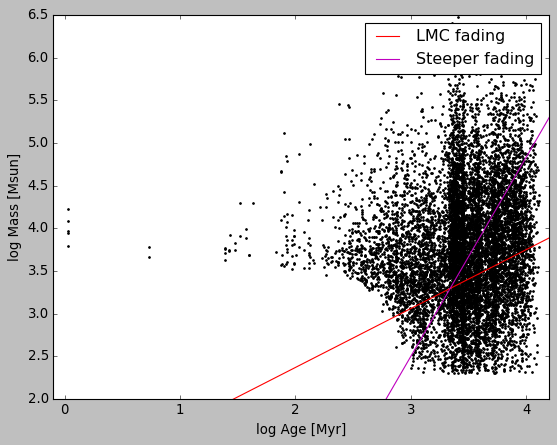

In [50]:
plt.scatter(np.log10(1e3*clus_age), np.log10(1e10*mclus), c='k', s=2)
logage = np.linspace(1, 4.2, 100)
fading1 = 0.69*logage + 0.99
fading2 = 7/3. * logage - 4.5
plt.plot(logage, fading1, c='r', label='LMC fading')
plt.plot(logage, fading2, c='m', label='Steeper fading')
plt.xlim(-.1, 4.2)
plt.ylim(2, 6.5)
plt.xlabel('log Age [Myr]')
plt.ylabel('log Mass [Msun]')
plt.legend()

In [51]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = sp.interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [67]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_icmf), nbins + 1)

mclus_i = s.data['imcl'].flatten()
mclus_m = s.data['mclt'].flatten()
mlsh = s.data['mlsk'].flatten()
mlrx = s.data['mlrx'].flatten()
drpt_t = s.data['drpt'].flatten()
drpt_t = drpt_t[mclus_i>0]
mclus_m = mclus_m[mclus_i>0]*1e10
mlsh = mlsh[mclus_i>0]*1e10
mlrx = mlrx[mclus_i>0]*1e10
mclus_i = mclus_i[mclus_i>0]*1e10

fraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  mask_disrupted = (drpt_t[mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)
drpt_t = s.cosmology_get_lookback_time_from_a(drpt_t, is_flat=True)

massfraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())

massfraction = np.array(massfraction)
massfraction = np.nan_to_num(massfraction, nan=0.)

/tmp/ipykernel_3232498/444049505.py:20: RuntimeWarning: invalid value encountered in long_scalars
  fraction.append(mask_disrupted.sum()/mask.sum())
/tmp/ipykernel_3232498/444049505.py:29: RuntimeWarning: invalid value encountered in float_scalars
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())


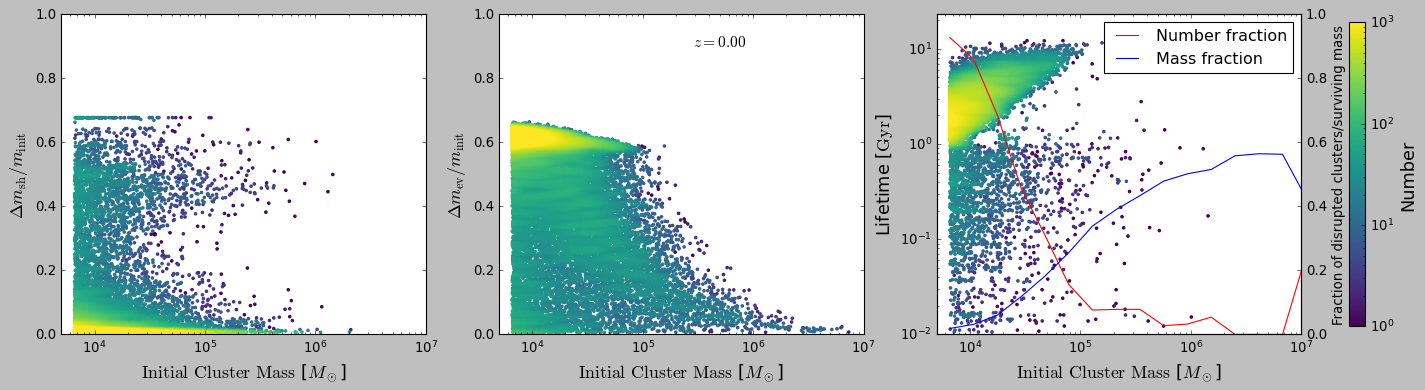

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(mclus_i, mlsh/mclus_i, vmin=1e0, vmax=1e3, ax=ax[0],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[0].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[0].set_ylabel(r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1], cb1 = density_scatter(mclus_i, mlrx/mclus_i, vmin=1e0, vmax=1e3, ax=ax[1],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].text(5e5, 0.9, r'$z={:.2f}$'.format(s.redshift), fontsize=14, ha='center')
ax[1].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[1].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[1].set_ylabel(r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$', fontsize=16)
ax[1].tick_params(labelsize=12)

ax[2], cb = density_scatter(mclus_i, np.repeat(stars_age,s.data['incl']) - drpt_t, vmin=1e0, vmax=1e3, ax=ax[2], bins=[10**marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax[2].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[2].set_ylabel(r'Lifetime [$\rm{Gyr}$]', fontsize=16)
ax[2].tick_params(labelsize=12)
ax2 = ax[2].twinx()
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, fraction, color='r', label='Number fraction')
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, massfraction, color='b', label='Mass fraction')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters/surviving mass')
ax2.legend()
cbar_ax = fig.add_axes([.93, 0.12, 0.01, 0.76])
cbar = fig.colorbar(cb, cax=cbar_ax)
cbar.set_label('Number', size=16)
# # plt.savefig('lostmass_old.pdf')